# Fitting Saturation-based Simulation Data With Multi-Output
Can having multiple labels per data improve validation loss? 


In [86]:
from pathlib import Path
import json
from torch.optim import Adam, SGD
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from model_trainer import RandomSplit, ValidationMethod, HoldOneOut, CVSplit, CombineMethods
from inverse_modelling_tfo.model_training.custom_models import (
    PerceptronBD,
    CNN2FC,
    FeatureResidualNetwork,
    CNN2FC2dInput,
    SplitChannelCNN
)

from inverse_modelling_tfo.visualization import generate_model_error_and_prediction
import torchinfo
from inverse_modelling_tfo.misc.misc_training import set_seed

# Set my GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [87]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Pre-save data

In [88]:
# file_name = 'logI2_by_I1'
# file_name = 'I1_and_I2'
file_name = 'pulsation_ratio'
# Load data
DATA_PATH = Path().resolve().parent.parent / "data" / "processed_data" / f"{file_name}.pkl"
data = pd.read_pickle(DATA_PATH)

# Load Configs
CONFIG_PATH = Path().resolve().parent.parent / "data" / "processed_data" / f"{file_name}.json"
with open(CONFIG_PATH, "r") as f:
    config = json.load(f)
labels = config["labels"]
features = config["features"]

# Convert to log
# data[features] = np.log(data[features])


# Cleanup
data.dropna(inplace=True)

In [90]:
data.describe()

,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Saturation,FconcCenters,Fetal Hb Concentration 1,Fetal Hb Concentration 2,MAX_ACbyDC_WV1_10,MAX_ACbyDC_WV2_10,MAX_ACbyDC_WV1_15,...,MAX_ACbyDC_WV1_77,MAX_ACbyDC_WV2_77,MAX_ACbyDC_WV1_81,MAX_ACbyDC_WV2_81,MAX_ACbyDC_WV1_86,MAX_ACbyDC_WV2_86,MAX_ACbyDC_WV1_90,MAX_ACbyDC_WV2_90,MAX_ACbyDC_WV1_94,MAX_ACbyDC_WV2_94
count,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000,5.155920e+05,5.155920e+05,5.155920e+05,...,5.155920e+05,515592.000000,5.155920e+05,515592.000000,5.155920e+05,515592.000000,5.155920e+05,515592.000000,515592.000000,515592.000000
mean,19.000000,13.000000,0.950000,0.400000,4.000000,12.675000,13.000000,1.411240e-06,3.376505e-05,2.079500e-05,...,5.167412e-03,0.011990,7.992776e-03,0.011946,1.043855e-02,0.016533,1.287112e-02,0.013400,0.014410,0.015443
std,8.944281,1.290996,0.031623,0.121106,2.738615,1.335075,1.369308,6.157235e-06,1.084815e-04,7.589912e-05,...,4.950300e-03,0.007352,8.048839e-03,0.007520,1.225728e-02,0.009174,1.241649e-02,0.007242,0.011877,0.011274
min,4.000000,11.000000,0.900000,0.200000,0.000000,10.725000,11.000000,-1.508303e-05,-1.703331e-05,-8.960152e-06,...,-2.021433e-07,0.000022,-2.166916e-07,0.000005,-2.575958e-07,0.000008,1.303757e-07,0.000602,0.000000,0.000373
25%,11.000000,12.000000,0.920000,0.300000,1.750000,11.578125,11.875000,-1.195902e-06,-9.765043e-07,-5.402421e-07,...,7.462595e-06,0.002682,2.485400e-04,0.003796,2.068142e-04,0.013688,4.121076e-03,0.007661,0.006295,0.009344
50%,19.000000,13.000000,0.950000,0.400000,4.000000,12.675000,13.000000,2.797384e-07,9.488376e-07,4.183859e-07,...,4.229336e-03,0.015145,8.309671e-03,0.015614,9.271239e-03,0.016369,1.172110e-02,0.014362,0.013063,0.014700
75%,27.000000,14.000000,0.980000,0.500000,6.250000,13.771875,14.125000,1.895443e-06,4.015937e-06,1.855118e-06,...,8.957809e-03,0.016628,1.207775e-02,0.017194,1.369559e-02,0.021705,1.618462e-02,0.017538,0.019009,0.018992
max,34.000000,15.000000,1.000000,0.600000,8.000000,14.625000,15.000000,4.495940e-05,5.784464e-04,4.562211e-04,...,2.357835e-02,0.030904,4.472644e-02,0.027948,7.222281e-02,0.053360,1.150121e-01,0.047227,0.064247,0.075043


In [91]:
# Filter data so I don't have to wait for too long during training
data = data[
    (data["Maternal Wall Thickness"] >= 2.0)
    & (data["Maternal Wall Thickness"] <= 12.0)
    # & (np.round(data["Fetal Hb Concentration"], fconc_rounding).isin(groups_to_keep))
    & (data["Fetal Saturation"] > 0.3)
    & (data["Maternal Saturation"] > 0.95)
]
print("training with", len(data), "samples")

training with 48600 samples


# Setup Training Objective

In [92]:
y_columns = labels  # What to Predict
# Add New ConcDiff Column as a new label
# data["ConcDiff"] = data["Fetal Hb Concentration 1"] - data["Fetal Hb Concentration 0"]
# if "ConcDiff" not in y_columns:
#     y_columns.append("ConcDiff")

# if "Fetal Hb Concentration 1" in y_columns:
#     y_columns.remove("Fetal Hb Concentration 1")

# if "Fetal Hb Concentration 0" in y_columns:
#     y_columns.remove("Fetal Hb Concentration 0")

if "FconcCenters" in y_columns:
    y_columns.remove("FconcCenters")
print("Y Columns", y_columns)

x_columns = features  # What to use as input
print("X Columns", x_columns)

Y Columns ['Maternal Wall Thickness', 'Maternal Hb Concentration', 'Maternal Saturation', 'Fetal Saturation', 'Fetal Hb Concentration 1', 'Fetal Hb Concentration 2']
X Columns ['MAX_ACbyDC_WV1_10', 'MAX_ACbyDC_WV1_15', 'MAX_ACbyDC_WV1_19', 'MAX_ACbyDC_WV1_24', 'MAX_ACbyDC_WV1_28', 'MAX_ACbyDC_WV1_33', 'MAX_ACbyDC_WV1_37', 'MAX_ACbyDC_WV1_41', 'MAX_ACbyDC_WV1_46', 'MAX_ACbyDC_WV1_50', 'MAX_ACbyDC_WV1_55', 'MAX_ACbyDC_WV1_59', 'MAX_ACbyDC_WV1_64', 'MAX_ACbyDC_WV1_68', 'MAX_ACbyDC_WV1_72', 'MAX_ACbyDC_WV1_77', 'MAX_ACbyDC_WV1_81', 'MAX_ACbyDC_WV1_86', 'MAX_ACbyDC_WV1_90', 'MAX_ACbyDC_WV1_94', 'MAX_ACbyDC_WV2_10', 'MAX_ACbyDC_WV2_15', 'MAX_ACbyDC_WV2_19', 'MAX_ACbyDC_WV2_24', 'MAX_ACbyDC_WV2_28', 'MAX_ACbyDC_WV2_33', 'MAX_ACbyDC_WV2_37', 'MAX_ACbyDC_WV2_41', 'MAX_ACbyDC_WV2_46', 'MAX_ACbyDC_WV2_50', 'MAX_ACbyDC_WV2_55', 'MAX_ACbyDC_WV2_59', 'MAX_ACbyDC_WV2_64', 'MAX_ACbyDC_WV2_68', 'MAX_ACbyDC_WV2_72', 'MAX_ACbyDC_WV2_77', 'MAX_ACbyDC_WV2_81', 'MAX_ACbyDC_WV2_86', 'MAX_ACbyDC_WV2_90', 'MAX

## Normalizing Features
x_columns will be the input features and y_columns are the target

In [93]:
## Pass in maternal info
# x_columns += ["Maternal Hb Concentration", "Maternal Saturation"]
# x_columns = list(filter(lambda X: 'alpha' in X, data.columns))
## Scale y
y_scaler = preprocessing.StandardScaler()
data[y_columns] = y_scaler.fit_transform(data[y_columns])

## Scale x
## Scheme 1 - Per detector normalization
x_scaler = preprocessing.StandardScaler()
data[x_columns] = x_scaler.fit_transform(data[x_columns])

## Scheme 2 - All detector combined normalization
# x_scaler = preprocessing.StandardScaler()
# # Assume the entire data lies between -1 to -20 (log scale) -> z = (x - u) / s -> zs - x = -u; s = 19/2 = 9.5;
# # at z = +1, x = -1, at z = -1, x = -20, u = 10.5, so we should be converting from -1 to -20 to -1 to 1
# # Use these values to manually define the scaler
# feature_len  = len(x_columns)
# x_scaler.scale_ = np.array([9.5] * feature_len)
# x_scaler.mean_ = np.array([10.5] * feature_len)
# x_scaler.n_features_in_ = feature_len
# x_scaler.feature_names_in_ = x_columns  # Avoids a warning/not really necessary
# data[x_columns] = x_scaler.transform(data[x_columns])


# Custom Loss Definition

In [94]:
class WeightedMSE(nn.Module):
    """
    MSE Loss for vector output labels with custom weighting
    """
    def __init__(self, loss_weights: torch.Tensor) -> None:
        super().__init__()
        # Reshape to row vector for broadcasting during loss calculation
        self.loss_weights = loss_weights.reshape(1, -1)
        self.mse_loss = nn.MSELoss(reduction='none')

    
    def forward(self, predicted_tmps, targets):
        loss = self.mse_loss(predicted_tmps, targets)
        loss = loss * self.loss_weights
        return loss.sum() / self.loss_weights.sum()

## Model Configuration

In [95]:
print("In Features :", len(x_columns))  
print("Out Features:", len(y_columns))

In Features : 40
Out Features: 6


# Setting up Special Residual Network 

In [96]:
# saturation_unique_values = data["Fetal Saturation"].unique()
# mean_saturation_level = saturation_unique_values[len(saturation_unique_values)//2]
# # Convert to float tensor, by default it is double
# lookup_table = torch.from_numpy(data[data["Fetal Saturation"] == mean_saturation_level].values).cuda().float()
# feature_indices = [data.columns.get_loc(feature) for feature in x_columns]
# feature_indices = torch.tensor(feature_indices).cuda()
# intermediate_labels = y_columns.copy()
# intermediate_labels.remove("Fetal Saturation")
# intermediate_label_indices = [data.columns.get_loc(label) for label in intermediate_labels]
# intermediate_labels = torch.tensor(intermediate_label_indices).cuda()

# # y_columns = ["Fetal Saturation"]

# feature_res_net_params = {
#         'node_count_left': [len(x_columns), 5, len(intermediate_labels)],
#         'dropout_rates_left': [0.5, 0.5],
#         'node_count_right': [len(x_columns), 5, len(y_columns)],
#         'dropout_rates_right': [0.5, 0.5],
#         'lookup_table': lookup_table,
#         'lookup_key_indices': intermediate_labels,
#         'feature_indices': feature_indices,
# }


# Training Configs

In [136]:
IN_FEATURES = len(x_columns)
OUT_FEATURES = len(y_columns)

from model_trainer import ModelTrainer, TorchLossWrapper, DataLoaderGenerator

criterion = TorchLossWrapper(nn.MSELoss())
# criterion = TorchLossWrapper(nn.HuberLoss())

set_seed(40)

# validation_method = RandomSplit(0.7)
all_depths = data["Maternal Wall Thickness"].unique()
all_depths.sort()
validation_method = HoldOneOut('Maternal Wall Thickness', all_depths[len(all_depths)//2])   # Center value

dataloader_gen = DataLoaderGenerator(data, x_columns, y_columns, 32, {'shuffle': True})

## Trainer Factory - Perceptrons
# model = PerceptronBD([IN_FEATURES, 40, 20, 10, 6, OUT_FEATURES])    # Works
model = PerceptronBD([IN_FEATURES, 40, 20, OUT_FEATURES])    
# trainer_factory = ModelTrainerFactory(PerceptronBD, {'node_counts' : [IN_FEATURES, 40, 20, 10, OUT_FEATURES], 'dropout_rates': [0.5, 0.5, 0.5]}, generate_data_loaders, datagen_kw, 100, criterion)
# trainer_factory = ModelTrainerFactory(PerceptronBD, {'node_counts' : [IN_FEATURES, 25, 12, 8, OUT_FEATURES], 'dropout_rates': [0.5, 0.5, 0.5]}, generate_data_loaders, datagen_kw, 100, criterion)
# trainer_factory = ModelTrainerFactory(PerceptronBD, {'node_counts' : [IN_FEATURES, 10, 10, 5, 5, OUT_FEATURES], 'dropout_rates': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]}, generate_data_loaders, datagen_kw, 100, criterion)
# trainer_factory = ModelTrainerFactory(PerceptronBD, {'node_counts' : [IN_FEATURES, 40, 20, 10, 5, OUT_FEATURES], 'dropout_rates': [0.5] * 5}, generate_data_loaders, datagen_kw, 100, criterion)
# trainer_factory = ModelTrainerFactory(FeatureResidualNetwork, feature_res_net_params, generate_data_loaders, datagen_kw, 100, criterion)

## Trainer Factory - CNNs
# cnn_config = {
#     'input_length': IN_FEATURES,
#     'cnn_out_channels': [4, 8, 16],
#     'cnn_kernel_sizes' : [10, 10, 10],
#     'fc_output_node_counts': [20, 10, OUT_FEATURES],
# }
# trainer_factory = ModelTrainerFactory(CNN2FC2dInput, cnn_config, generate_data_loaders, datagen_kw, 100, criterion)

## Trainer Factory - SplitChannel CNNs
# cnn_config = {
#     'complete_input_length': IN_FEATURES,
#     'split_count': 4,
#     'cnn_out_channels': [4, 8, 16],
#     # 'cnn_kernel_sizes' : [10, 5, 5],
#     'cnn_kernel_sizes' : [10, 5, 3],
#     'cnn_dropouts' : [0.5] * 2,
#     # 'fc_output_node_counts': [30, 10, OUT_FEATURES],    # Best
#     # 'fc_output_node_counts': [24, 12, OUT_FEATURES],    # Best
#     'fc_output_node_counts': [12, 6, OUT_FEATURES],    # Best
#     'fc_dropouts': [0.5] * 3,
# }

# model = SplitChannelCNN(**cnn_config)

trainer = ModelTrainer(model, dataloader_gen, validation_method, criterion)

## Custom Training

In [137]:
trainer.set_optimizer(SGD, {'lr': 2e-3, 'momentum': 0.98, 'weight_decay': 1e-4})
# trainer.set_batch_size(2048)
# trainer.set_batch_size(32)
trainer.run(50) 

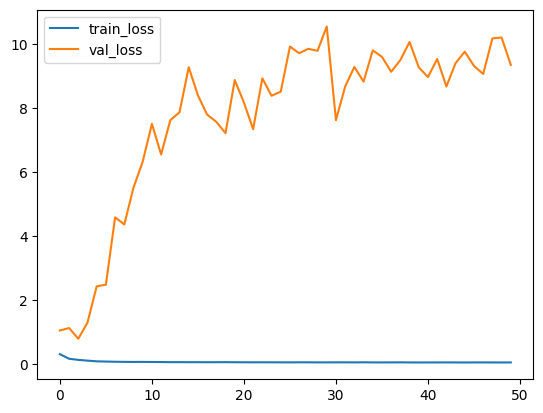

In [138]:
plt.figure()
criterion.loss_tracker.plot_losses()
# plt.yscale('log')
plt.legend()

loss_curves = plt.gcf()

In [139]:
print(trainer)


        Model Properties:
        PerceptronBD(
  (model): Sequential(
    (0): Linear(in_features=40, out_features=40, bias=True)
    (1): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=40, out_features=20, bias=True)
    (4): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=20, out_features=6, bias=True)
    (7): Flatten(start_dim=1, end_dim=-1)
  )
)
        Data Loader Properties:
        48600 rows, 40 x columns, 6 y columns
        Batch Size: 32
        X Columns: ['MAX_ACbyDC_WV1_10', 'MAX_ACbyDC_WV1_15', 'MAX_ACbyDC_WV1_19', 'MAX_ACbyDC_WV1_24', 'MAX_ACbyDC_WV1_28', 'MAX_ACbyDC_WV1_33', 'MAX_ACbyDC_WV1_37', 'MAX_ACbyDC_WV1_41', 'MAX_ACbyDC_WV1_46', 'MAX_ACbyDC_WV1_50', 'MAX_ACbyDC_WV1_55', 'MAX_ACbyDC_WV1_59', 'MAX_ACbyDC_WV1_64', 'MAX_ACbyDC_WV1_68', 'MAX_ACbyDC_WV1_72', 'MAX_ACbyDC_WV1_77', 'MAX_ACbyDC_WV1_81', 'MAX_ACbyDC_W

In [140]:
# Increase batch_size for faster visuals generation - (does not affect training!)
prev_batch_size = dataloader_gen.batch_size
trainer.set_batch_size(4096)
train_error, train_pred = generate_model_error_and_prediction(trainer.model, trainer.train_loader, y_columns, y_scaler)
val_error, val_pred = generate_model_error_and_prediction(trainer.model, trainer.validation_loader, y_columns, y_scaler)
trainer.set_batch_size(prev_batch_size)

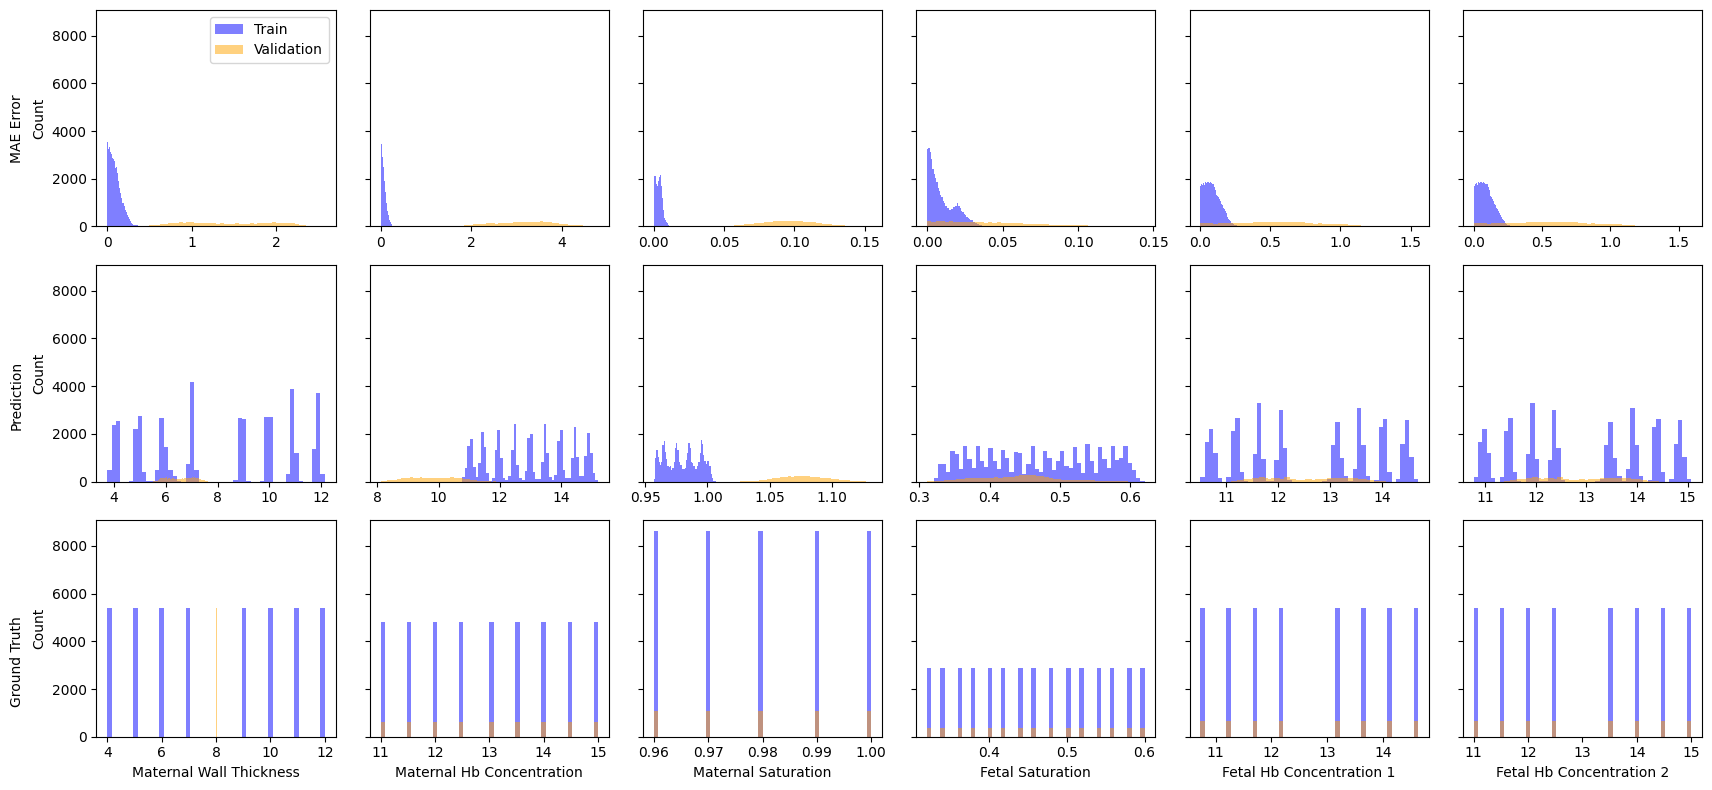

In [141]:
fig_dist, axes = plt.subplots(3, len(y_columns), squeeze=True, figsize=(17, 8), sharey=True)
BIN_COUNT = 50

train_data = y_scaler.inverse_transform(trainer.train_loader.dataset[:][1].cpu())
val_data = y_scaler.inverse_transform(trainer.validation_loader.dataset[:][1].cpu())

for i in range(len(y_columns)):
    # Plot Errors
    ax = axes[0, i]
    plt.sca(ax)
    column_name = train_error.columns[i]
    plt.hist(train_error[column_name], bins=BIN_COUNT, color='blue', alpha=0.5, label='Train')
    plt.hist(val_error[column_name], bins=BIN_COUNT, color='orange', alpha=0.5, label='Validation')

    
    # Plot Predictions
    ax = axes[1, i]
    plt.sca(ax)
    column_name = train_pred.columns[i]
    plt.hist(train_pred[column_name], bins=BIN_COUNT, color='blue', alpha=0.5, label='Train')
    plt.hist(val_pred[column_name], bins=BIN_COUNT, color='orange', alpha=0.5, label='Validation')

    
    # Plot Ground Truth
    ax = axes[2, i]
    plt.sca(ax)
    plt.hist(train_data[:, i], bins=BIN_COUNT, color='blue', alpha=0.5, label='Train')
    plt.hist(val_data[:, i], bins=BIN_COUNT, color='orange', alpha=0.5, label='Validation')

    # X Label for the bottommost row
    plt.xlabel(y_columns[i])
    
# Add text to the left of each row of plots
for i, label in enumerate(['MAE Error', 'Prediction', 'Ground Truth']):
    fig_dist.text(0, (2.5-i)/3, label, ha='center', va='center', rotation='vertical')

# Y Labels
for i in range(axes.shape[0]):
    axes[i, 0].set_ylabel('Count')

# Add labels to top-left subplot
axes[0, 0].legend()


plt.tight_layout()
plt.show()

In [142]:
# # Top Bad Samples
# VIEW_TOP_N = 50
# worst_errors = error_df['Absolute Error'].argsort()[::-1][:VIEW_TOP_N]  # Worst Results
# # worst_errors = error_df['Absolute Error'].argsort()[:VIEW_TOP_N]  # Best Results
# combined_table = data.join(error_df)
# with pd.option_context("display.max_rows", None):
#     display(combined_table[['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Hb Concentration", "Fetal Saturation", 'Truth', 'Predicted', 'Absolute Error', '%tage']].iloc[worst_errors, :])

In [143]:
# # Rough MSE's in percentage
# print(f'Train Error(non-normalized): {trainer.train_loss[-1] * y_scaler.var_ }')
# print(f'Validation Error(non-normalized): {trainer.validation_loss[-1] * y_scaler.var_ }')

In [144]:
# Model Info
torchinfo.summary(trainer.model)

Layer (type:depth-idx)                   Param #
PerceptronBD                             --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       1,640
│    └─BatchNorm1d: 2-2                  80
│    └─ReLU: 2-3                         --
│    └─Linear: 2-4                       820
│    └─BatchNorm1d: 2-5                  40
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       126
│    └─Flatten: 2-8                      --
Total params: 2,706
Trainable params: 2,706
Non-trainable params: 0

In [145]:
# ## Save Model Code
# model_name = 'multi_output_holdoneout_split'
# import joblib
# # Save Model
# torch.save(model.state_dict(), rf'../../models/{model_name}')
# # Save the Scalers for Later Use
# joblib.dump(x_scaler, rf'../../models/{model_name}_xscaler')
# joblib.dump(y_scaler, rf'../../models/{model_name}_yscaler')

['../../models/multi_output_holdoneout_split_yscaler']

In [146]:
# # Load Model Code
# model = PerceptronReLU([20, 10, 4, 2, 1])
# model.load_state_dict(torch.load(r'../models/fsat_delta_5det_v1'))
# model = model.cuda()
# x_scaler = joblib.load(rf'../models/{model_name}_xscaler')
# y_scaler = joblib.load(rf'../models/{model_name}_yscaler')

In [147]:
# from inverse_modelling_tfo.misc import MarkdownReport
# # Generate report

# report = MarkdownReport(Path('results'), 'report7', 'Inverse Modelling Report')
# report.add_text_report("Objective", "Predicting with 90% Random Split(As opposed to a hold One out style). Same as report6. Except, trying out a different normalization scheme. Where it scales all detector intensity logs using a single scale. More specifically, maps the values from -1 to -20 between -1 and +1. The intuition behind this was that this sort of normalization should preserve inter-detector scaling.")
# report.add_text_report("Comments", "Somehow performs slightly worse than per detector scaling. Which does not make sense to me")
# report.add_text_report("Data Length", str(len(data)))
# report.add_code_report("Model Used", str(torchinfo.summary(trainer.model)))
# report.add_code_report("Model Trainer Params", str(trainer))
# report.add_image_report("Loss Curves", loss_curves)
# report.add_image_report("Prediction & Error Distribution", fig_dist)
# report.save_report()